# Time Series Analysis and Forecasting with statsmodels

## Josef Perktold


## about me

- applied econometrics, computer science (Master)
- economic theory (PhD)
- software for statistics and economtrics   
  - user-developer with various packages and with GAUSS, Matlab, Python
  - scipy.stats
  - statsmodels
- "self-taught statistician"

  
## about statsmodels

- precursor: scipy.stats.models
- 7 years of development
- started with GSOC Skipper Seabold
- slow and steady growth since then
- GSOC Chad Fulton statespace models
- open source, BSD licensed
- ~ 130,000 LOC of Python (including some Cython)

## Brief Overview - Time Series Analysis in Statsmodels

- Data Handling through Pandas
- statistics
  - acf, pacf
  - filters, seasonal decomposition
  - hypothesis tests: unit root, Granger causality
- ARMA, ARIMAX
- VAR (vector autoregressive models)
- new statespace models
  - SARIMAX
  - ...
- postestimation: predict, impulse response, hypothesis testing

two GSOC projects in 2016 for TSA

## Forecasting with SARIMAX models

### Seasonal AutoRegressive Integrated Moving Average models with eXplanatory variables


![alternate text](images/airpassenger_forecast.png)

## Topics

### OLS with serially correlated errors

### Stationarity

### Transformation to Stationarity

### Fitting and Selecting Models

### Prediction and Forecasting

In [1]:
%matplotlib inline

In [2]:

import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
#plt.interactive(False)   # otherwise interactive(False)

## El Nino temperature data

In [3]:
from statsmodels.datasets.elnino import load_pandas

datadf = load_pandas()
datadf.data
temperature = np.asarray(datadf.data.iloc[:, 1:]).ravel()
nobs = len(temperature)
index = pd.date_range("1950-01-01", periods=nobs, freq='MS')
months = np.tile(np.arange(12), nobs // 12)
df_el = pd.DataFrame({'temperature': temperature, 'month': months}, index=index)
df_el.tail()

,month,temperature
2010-08-01,7,19.49
2010-09-01,8,19.28
2010-10-01,9,19.73
2010-11-01,10,20.44
2010-12-01,11,22.07


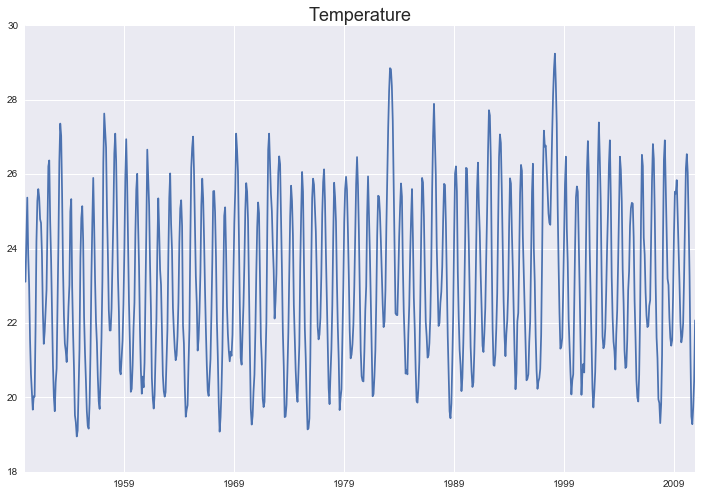

In [4]:
ax = df_el['temperature'].plot()
ax.figure.set_size_inches(12, 8)
ax.set_title('Temperature', fontsize=18)

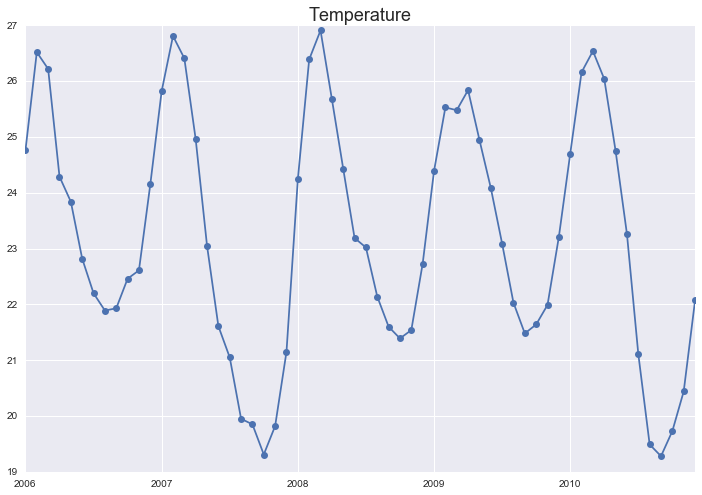

In [5]:
ax = df_el['temperature'].iloc[-12*5:].plot(style='-o')
ax.figure.set_size_inches(12, 8)
_ = ax.set_title('Temperature', fontsize=18)

In [6]:
res_ols = sm.formula.ols('temperature ~ C(month)', df_el.iloc[:-3*12]).fit()
predicted = res_ols.predict(df_el.iloc[-3*12:])
fitted = res_ols.fittedvalues.loc['2005-12-01':]  # 5 years

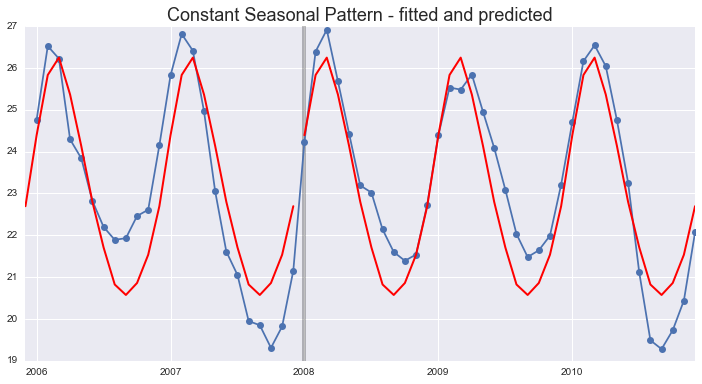

In [7]:
ax = df_el['temperature'].iloc[-12*5:].plot(style='-o')
ax.figure.set_size_inches(12, 6)
fitted.plot(lw=2, color='r')
predicted.plot(lw=2, color='r')
ax.vlines(predicted.index[0], lw=4, alpha=0.25, *ax.get_ylim())
_ = ax.set_title('Constant Seasonal Pattern - fitted and predicted', fontsize=18)

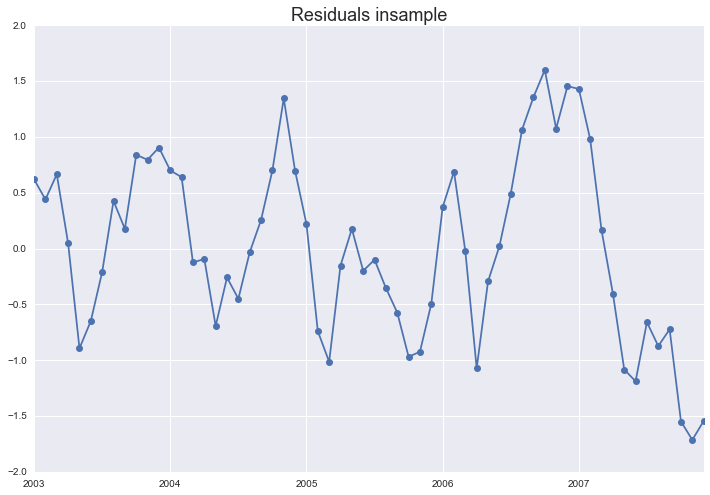

In [8]:
ax = res_ols.resid.iloc[-5*12:].plot(style='-o',figsize=(12,8))
_ = ax.set_title('Residuals insample', fontsize=18)

In [9]:
import statsmodels.tsa.api as smt
def cfplot(y, lags=None, figsize=(10, 8)):
    fig = plt.figure(figsize=figsize)
    layout = (2, 1)
    acf_ax = plt.subplot2grid(layout, (0, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 0))
    
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(1.5) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return acf_ax, pacf_ax

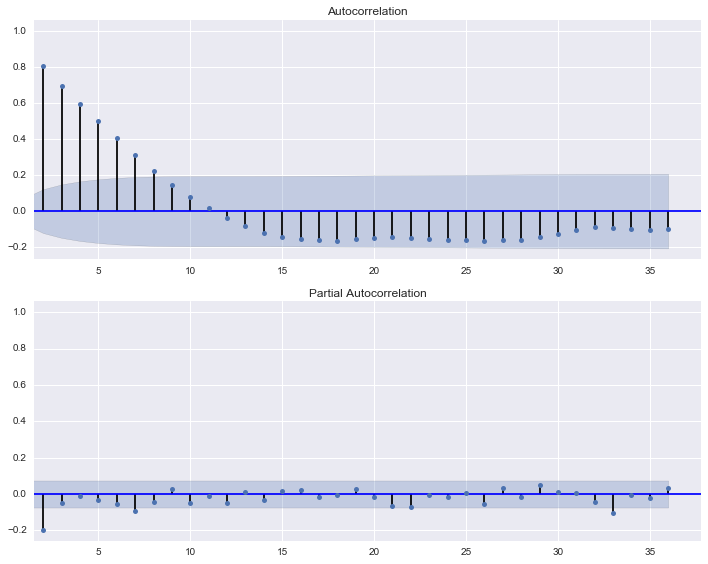

In [10]:
_ = cfplot(res_ols.resid, lags=36)

In [11]:
import patsy
y, x = patsy.dmatrices('temperature ~ C(month)', df_el, return_type='dataframe')
res_arma = sm.tsa.ARMA(y, order=(2, 1), exog=x.iloc[:, 1:]).fit()

In [12]:
print(res_arma.summary())

                              ARMA Model Results                              
Dep. Variable:            temperature   No. Observations:                  732
Model:                     ARMA(2, 1)   Log Likelihood                -414.032
Method:                       css-mle   S.D. of innovations              0.425
Date:                Thu, 02 Jun 2016   AIC                            860.064
Time:                        15:24:59   BIC                            933.597
Sample:                    01-01-1950   HQIC                           888.430
                         - 12-01-2010                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                24.3818      0.156    156.691      0.000      24.077      24.687
C(month)[T.1]         1.4486      0.055     26.240      0.000       1.340       1.557
C(month)[T.2]         1.

In [13]:
pred_dynamic = res_arma.predict(start='2008-12-01', end='2010-12-01', exog=res_arma.model.exog[-3*12:, 1:], dynamic=True)
fitted = res_arma.fittedvalues

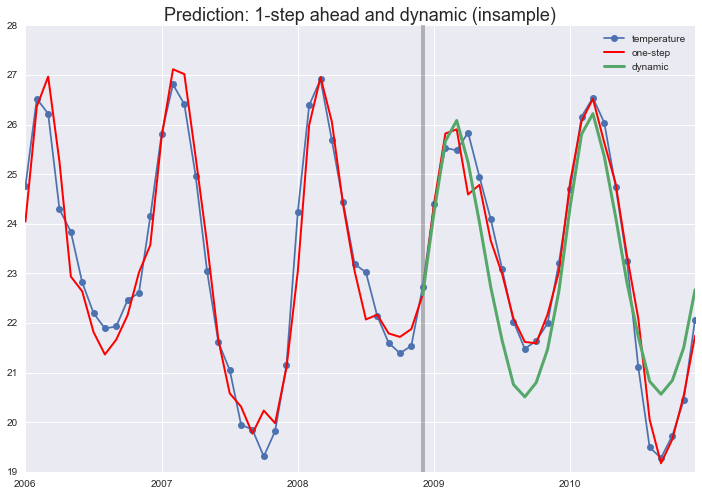

In [14]:
ax = df_el['temperature'].iloc[-12*5:].plot(style='-o')
ax.figure.set_size_inches(12, 8)
res_arma.fittedvalues.iloc[-5*12:].plot(lw=2, color='r', label='one-step')

pred_dynamic.plot(lw=3, label='dynamic')
ax.vlines('2008-12-01', lw=4, alpha=0.25, *ax.get_ylim())
ax.set_title('Prediction: 1-step ahead and dynamic (insample)', fontsize=18)
plt.legend()
_ = plt.savefig('images/elnino_forecast.png', bbox_inches='tight')

## Short term and long term forecasts

![alternate text](images/elnino_forecast.png)

## Summary ARMAX

### y = X b + e,   e ~ ARMA(p, q)

### use explanatory variables X to model stable, systematic part

- seasonal patterns: dummies, splines, fourier polynomials
- trend: linear, polynomial, or piecewise
- other effects: dummies for special events, outliers
- explanatory variables: related series that help in prediction, 
  (need forecasts for those, or use lagged values)
  
### use ARMA to improve short term forecasting

- e = y - X b
- use the additional information that is left after systematic part has been removed
- assumes what is left over is stationary

## Stationarity

### A time series is stationary if the distribution of the observations does not depend on time.

Often only mean, variance and autocovariance stationarity is relevant

no persistence: shocks or disturbances have not long term effect

mean reversion: the long term forecast moves to the mean of the series

### Random Walk  y(t) = y(t-1) + e(t)

The best forecast at time t $\hat{y}(t+1) = y(t)$ and $\hat{y}(t+h) = y(t)$

Tomorrow is like today.

seasonal y(t) = y(t - s) + e(t)

Tomorrow is like the same day last week (month, year)

### full persistence: every shock stays forever

y(t) is **integrated**, the differenced series is stationary

substituting back in

$y(t) = y(0) + \sum_{i=1}^{t} e(t-i)$


## Differencing - Modelling the change

### $y^* = y(t) - y(t - 1)$  ~ ARMA(p,q)

#### Instead of modelling the level, we model the change.

#### Forecasting change versus forecasting level.

### ARIMA(p, d, q) is ARMA after differencing d times, 

#### p AR lags, q MA lags

### $y(t) = a_1 y(t - 1) + ... + a_p y(t - p) + b_1 u(t - 1) + ... + b_q u(t - q)$

### SARIMA(P, D, Q)_s ARMA with seasonal lags and seasonal differencing, 

#### P seasonal AR lags, Q seasonal MA lags

### $y(t) = A_1 y(t - s) + ... + A_P y(t - P s) + B_1 u(t - s) + ... + B_Q u(t - Q s)$

## SARIMAX without X

### SARIMAX(endog, exog=None, order=(1, 0, 0), seasonal_order=(0, 0, 0, 0), trend=None, ...)


`endog` is endogenous, dependent variable (statsmodels econometrics history)

`exog` are eXogenous, independent, explanatory variables

`order` (p, d, q) is regular ARIMA

`seasonal_order` (P, D, Q, s) is seasonal ARIMA with season length s

example: SARIMA((1, 0, 0), (1, 0, 0, 12) only AR terms

### $(1 - a_1 \hspace{2mm} L) (1 - A_1 \hspace{2mm} L^{12}) y_t = y_t - a_1 \hspace{2mm} y_{t-1} - A_1 \hspace{2mm} y_{t-12} + a_1 \hspace{2mm} A_1  \hspace{2mm} y_{t-13}$

### $y_t = a_1 \hspace{2mm} y_{t-1} + A_1 \hspace{2mm} y_{t-12} - a_1 \hspace{2mm} A_1  \hspace{2mm} y_{t-13} \hspace{2mm} + ...$

## Model Selection and Automatic Forecasting

Hyndman has several supporting functions in R, auto.arima

statsmodels doesn't have much ready made and automatic

### Amount of Differencing

(standard maximum likelihood methods do not apply)

commonly based on unit root or stationarity tests

### Lag lengths, p, q, P, Q

loop over set of lag lengths and choose the model  <BR>
minimize AIC, BIC, or maximize out-of-sample forecast performance. 


If the dataset is long enough, then out of sample forecast performance can be used.
Standard cross-validation does not directly apply because of the serial dependence.

If there are convergence proplem, then the model is most likely not appropriate

We can use dummies for outlier observations as explanatory variables to remove their effect. Similarly, standard tools can be used to check for trend breaks.

### Outliers, ...

dummies for outlier observation, trend breaks, ...

## Example: Forecasting Bus Riders

see blog post and notebook for details

http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/





In [15]:
df = pd.read_csv('portland-oregon-average-monthly-.csv', index_col=0, skipfooter=2)
df.index.name=None
df.reset_index(inplace=True)

C:\Users\josef\Downloads\WinPython-64bit-3.4.4.2\python-3.4.4.amd64\lib\site-packages\ipykernel\__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skip_footer; you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


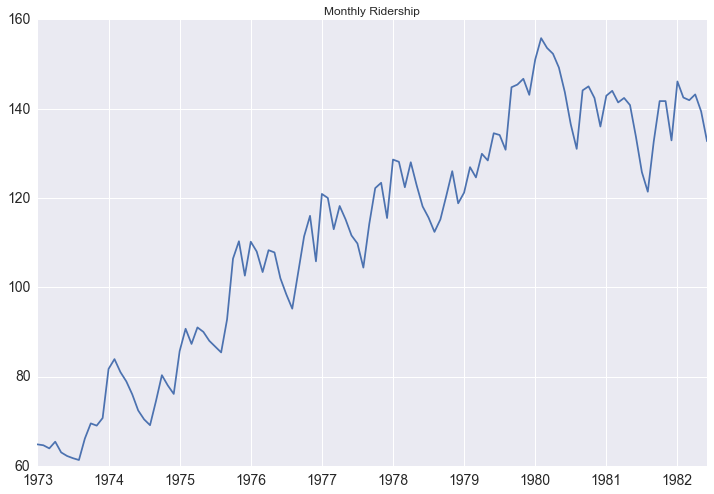

In [16]:
start = datetime.datetime.strptime("1973-01-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0, len(df))]
df['index'] = date_list
df.set_index(['index'], inplace=True)
df.index.name=None

df.columns= ['riders']
df['riders'] = df['riders'] / 10.

fig = df.riders.plot(figsize=(12,8), title= 'Monthly Ridership', fontsize=14)
plt.savefig('images/month_ridership.png', bbox_inches='tight')


![alternate text](images/month_ridership.png)

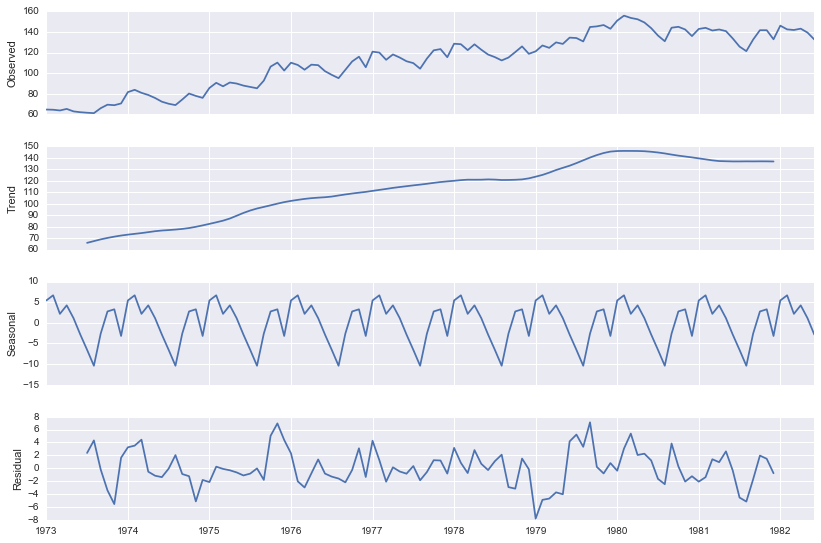

In [17]:
seas = seasonal_decompose(df['riders'])
fig = seas.plot()
fig.set_size_inches(12,8)

In [18]:

mod = sm.tsa.statespace.SARIMAX(df.riders, order=(0,1,0), seasonal_order=(1,1,1,12), trend='n')
results = mod.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             riders   No. Observations:                  114
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -268.775
Date:                            Thu, 02 Jun 2016   AIC                            543.550
Time:                                    15:25:04   BIC                            551.759
Sample:                                01-01-1973   HQIC                           546.881
                                     - 06-01-1982                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.3235      0.186      1.737      0.082      -0.042       0.688
ma.S.L12      -0.9989     39.033     -0.026      0.980     -77.502      75.504
sigma2         9.8489    383.190      0.026      0.979    -741.190     760.888
===================================================================================
Ljung-Box (Q):                       36.55   Jarque-Bera (JB):                 4.81
Prob(Q):                              0.63   Prob(JB):                         0.09
Heteroskedasticity (H):               1.48   Skew:                             0.38
Prob(H) (two-sided):                  0.26   Kurtosis:                         3.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

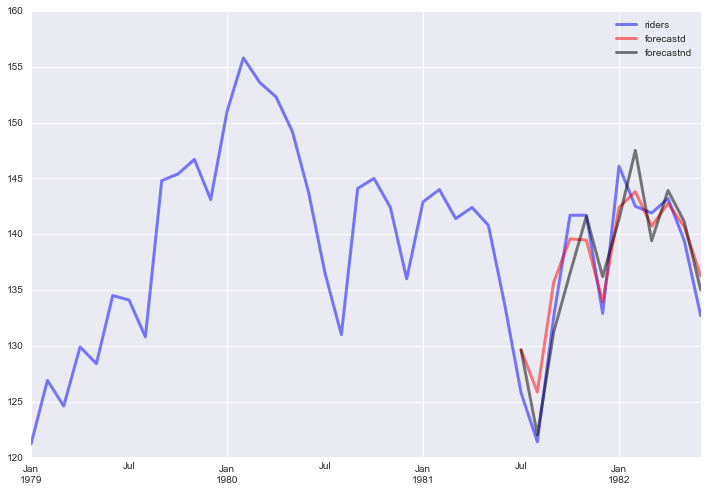

In [19]:
df['forecastd'] = results.predict(start=102, end=114, dynamic=True)  
df['forecastnd'] = results.predict(start=102, end=114, dynamic=False)
df[['riders', 'forecastd', 'forecastnd']].loc['1979-01-01':].plot(figsize=(12, 8), color='brk', lw=3, alpha=0.5) 
plt.savefig('images/ts_df_predict.png', bbox_inches='tight')

## SARIMAX and transformation

back to the initial plot


In [20]:
df_air = pd.read_csv('AirPassengers.csv', index_col=0)
di = pd.date_range("1949-01-01", periods=144, freq='MS')
df_air.set_index(di, inplace=True)
del df_air['time']
df_air.tail()

,AirPassengers
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


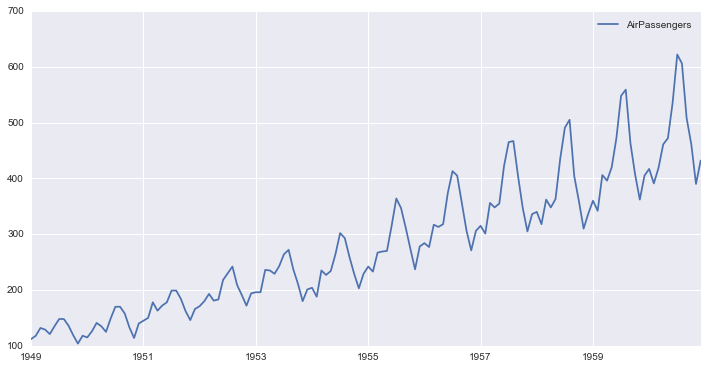

In [21]:
df_air.plot(figsize=(12,6))
plt.savefig('air_passenger.png', bbox_inches='tight')

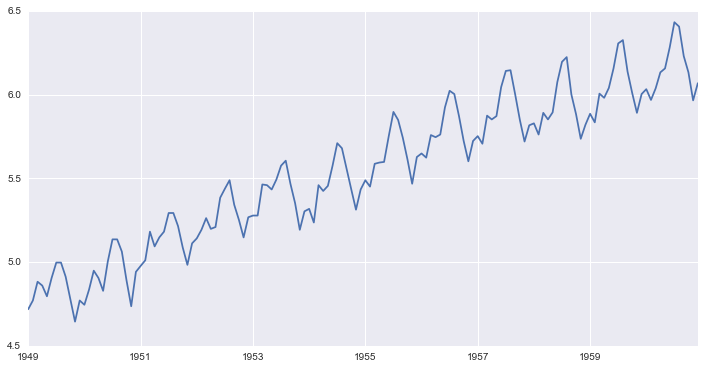

In [22]:
air_log = np.log(df_air['AirPassengers'])
air_log.plot(figsize=(12,6))

## Rolling Standard Deviation - orginal versus log transformed

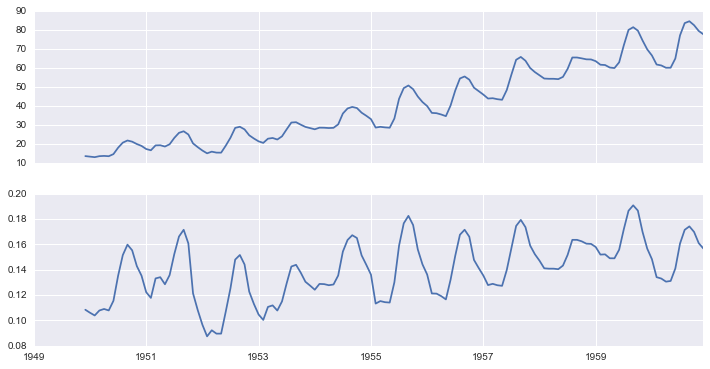

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,6))
_ = df_air['AirPassengers'].rolling(12).std().plot(ax=ax1)
_ = air_log.rolling(12).std().plot(ax=ax2)

## Rolling Standard Deviation - Box-Cox transformed

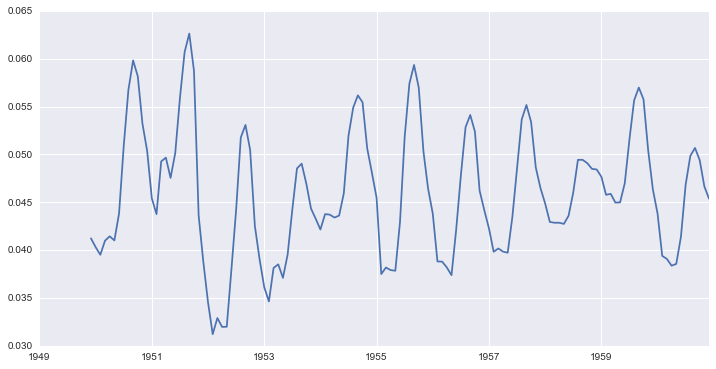

In [24]:
from scipy import special
ax = special.boxcox(df_air['AirPassengers'], -0.2).rolling(window=12).std().plot(figsize=(12,6))

In [25]:
def box_cox_rolling_coeffvar(box_cox_param, endog, freq):
    """helper to find Box-Cox transformation with constant standard deviation
    
    returns RLM results instance
    """
    roll_air = special.boxcox(endog, box_cox_param).rolling(window=freq)
    y = roll_air.std() 
    m = roll_air.mean()
    x = sm.add_constant(m)
    res_rlm = sm.RLM(y, x, missing='drop').fit()
    return res_rlm

endog = df_air['AirPassengers']
freq = 12
tt = [(lam, box_cox_rolling_coeffvar(lam, endog, freq).pvalues[1]) for lam in np.linspace(-1, 1, 21)]

tt = np.asarray(tt)
print(tt[tt[:,1].argmax()])

[-0.2         0.62121147]


## SARIMAX((1, 1, 1), (0, 1, 1, 12)) of transformed series

In [26]:
air_t = special.boxcox(df_air['AirPassengers'], -0.2)
res_s = sm.tsa.SARIMAX(air_t, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12)).fit()
res_s.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.1996,0.177,1.127,0.260,-0.147,0.547
ma.L1,-0.5999,0.154,-3.897,0.000,-0.902,-0.298
ma.S.L12,-0.6009,0.100,-6.018,0.000,-0.797,-0.405
sigma2,0.0002,1.67e-05,9.120,0.000,0.000,0.000


In [27]:
max_ar, max_ma = 3, 3
aic_full = pd.DataFrame(np.zeros((max_ar, max_ma), dtype=float))

# Iterate over all ARMA(p,q) models with p,q in [0,1, 2]
for p in range(max_ar):
    for q in range(max_ma):
        if p == 0 and q == 0:
            continue
            
        # Estimate the model with no missing datapoints
        mod = sm.tsa.statespace.SARIMAX(air_t, order=(p,1,q), seasonal_order=(0, 1, 1, 12), trend='c', enforce_invertibility=False)
        try:
            res = mod.fit()
            aic_full.iloc[p,q] = res.aic
        except:
            aic_full.iloc[p,q] = np.nan
            
print('min at ', np.asarray(aic_full).argmin())
aic_full

m:\josef_new\eclipse_ws\statsmodels\statsmodels_py34_pr\statsmodels\base\model.py:472: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


min at  7


,0,1,2
0,0.000000,-764.890953,-763.534483
1,-761.633653,-760.546620,-761.033586
2,-760.518611,NaN,-760.842710


In [28]:
res.mle_retvals

{'converged': True,
 'fcalls': 384,
 'fopt': -2.6904260771638686,
 'gopt': array([ 0.49837125,  0.00346083, -0.01111765,  0.00097116, -0.00066937,
        -0.00472909,  0.02208268]),
 'warnflag': 0}

In [29]:
pred = res_s.get_prediction(start='1960-12-01', end='1962-12-01')
pred_ci = pred.conf_int()

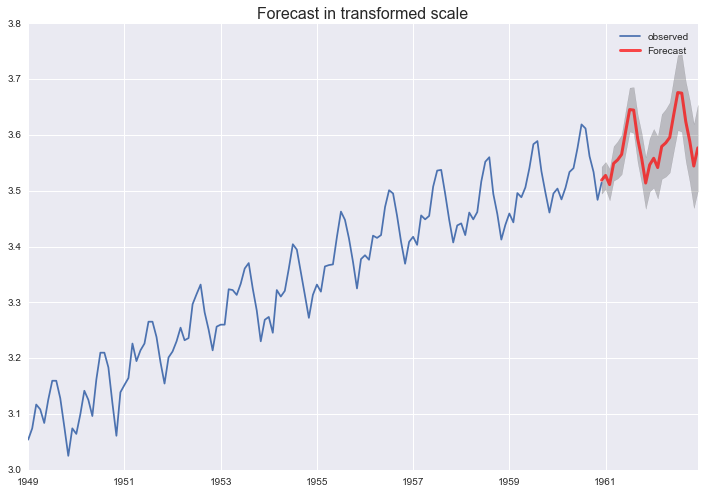

In [30]:
endog = air_t
ax = endog.plot(label='observed')
ax.figure.set_size_inches(12, 8)
pred.predicted_mean.plot(ax=ax, label='Forecast', lw=3, alpha=.7, color='r')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_title('Forecast in transformed scale', fontsize=16)
_ = plt.legend()
plt.savefig('images/airpassenger_forecast_boxcox.png', bbox_inches='tight')

![alternate text](images/airpassenger_forecast_boxcox.png)

## Transform forecast to original scale

In [31]:
pred_ci_orig = special.inv_boxcox(pred.conf_int(), -0.2)
forecast = special.inv_boxcox(pred.predicted_mean, -0.2)

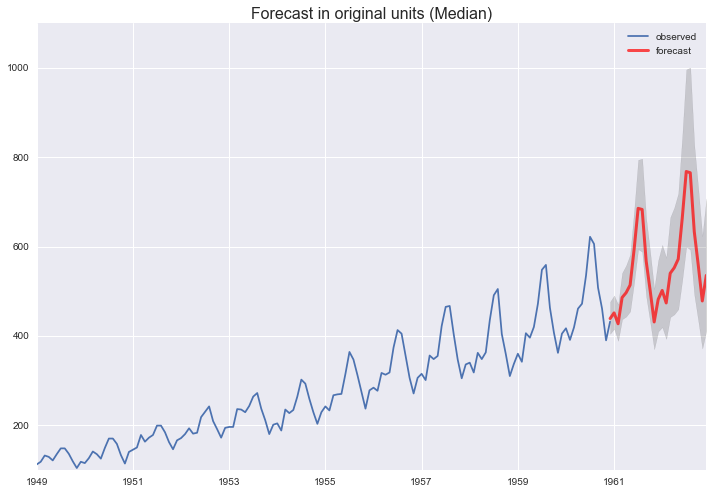

In [32]:
ax = df_air['AirPassengers'].plot(label='observed')
ax.figure.set_size_inches(12, 8)
forecast.plot(ax=ax, label='forecast', lw=3, alpha=.7, color='r')
ax.fill_between(pred_ci_orig.index,
                pred_ci_orig.iloc[:, 0],
                pred_ci_orig.iloc[:, 1], color='k', alpha=.15)
ax.set_title('Forecast in original units (Median)', fontsize=16)
plt.legend()
plt.savefig('images/airpassenger_forecast.png', bbox_inches='tight')

![alternate text](images/airpassenger_forecast.png)

## Summary SARIMA

### persistent features through differencing/integration

### short term adjustments through SARMA part

### stochastic trend and seasonality

### random walking, outliers ?

### long-term prediction intervals are very wide




## Beyond SARIMAX - UnobservedComponents

### $y_t = \mu_t + \gamma_t + c_t + \varepsilon_t$

- $y_t$ refers to the observation vector at time t, 
- $\mu_t$ refers to the trend component, 
- $\gamma_t$ refers to the seasonal component, 
- $c_t$ refers to the cycle, and 
- $\varepsilon_t$ is the irregular.

In [33]:
mod_ucarima = sm.tsa.UnobservedComponents(air_t, 'lltrend', seasonal=12, autoregressive=4)
res_ucarima = mod_ucarima.fit(method='powell', disp=0)

In [34]:
print(res_ucarima.summary())

                            Unobserved Components Results                            
Dep. Variable:                 AirPassengers   No. Observations:                  144
Model:                    local linear trend   Log Likelihood                 383.095
                   + stochastic seasonal(12)   AIC                           -748.190
                                     + AR(4)   BIC                           -721.462
Date:                       Thu, 02 Jun 2016   HQIC                          -737.329
Time:                               15:25:16                                         
Sample:                           01-01-1949                                         
                                - 12-01-1960                                         
Covariance Type:                         opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------

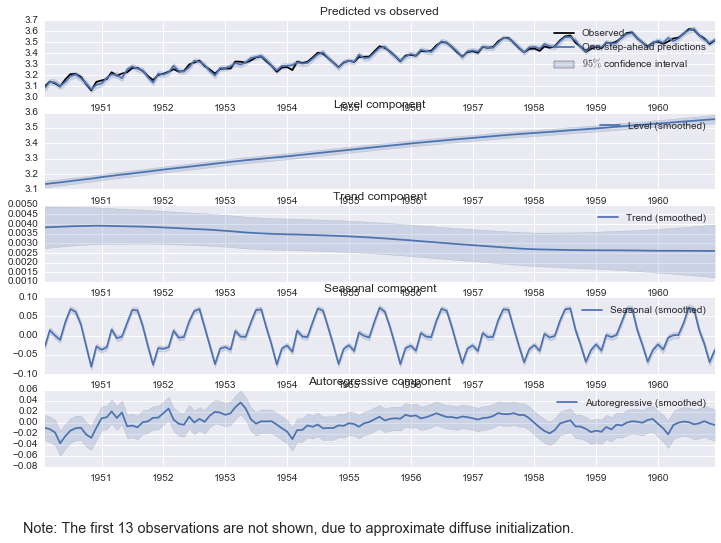

In [35]:
fig_uc = res_ucarima.plot_components()
fig_uc.set_size_inches(12, 8)

In [36]:
pred_uc = res_ucarima.get_forecast(steps=24)
pred_ci = pred.conf_int()
#pred_uc.predicted_mean

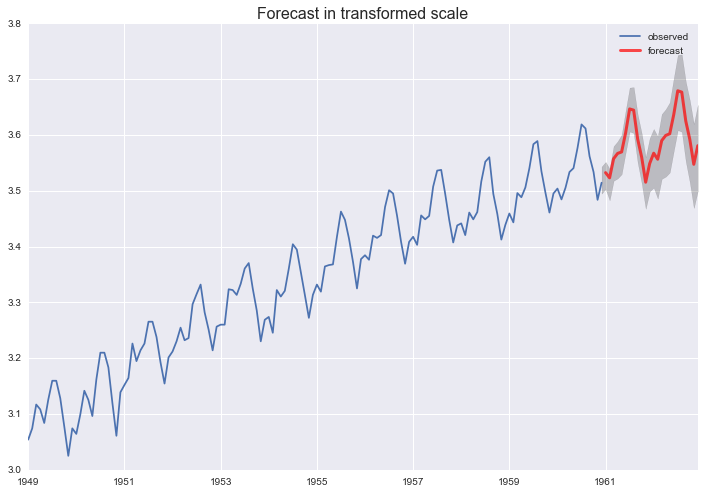

In [37]:
ax = air_t.plot(label='observed')
ax.figure.set_size_inches(12, 8)
pred_uc.predicted_mean.plot(ax=ax, label='forecast', lw=3, alpha=.7, color='r')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_title('Forecast in transformed scale', fontsize=16)
_ = plt.legend()
plt.savefig('images/airpassenger_forecast_uc.png', bbox_inches='tight')

![alternate text](images/airpassenger_forecast_uc.png)

## References

### documentation

http://www.statsmodels.org/dev/tsa.html

http://www.statsmodels.org/dev/statespace.html

http://www.statsmodels.org/dev/examples/index.html

### blog posts

http://tomaugspurger.github.io/modern-7-timeseries.html  Pandas usage

http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/

http://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/


I will clean up notebook during weekend


# Statsmodels 0.8


## in preparation


0.7 was never really released

## Thank you


## https://github.com/statsmodels/statsmodels

## http://www.statsmodels.org/dev/index.html
